In [1]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.api.types import CategoricalDtype
from sklearn import linear_model
from sklearn.metrics import RocCurveDisplay, auc, mean_squared_error, roc_curve
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.utils.fixes import loguniform

from label_flip_revised.utils import create_dir

In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)

/home/lukec/workspace/diva_01


In [3]:
path_output = os.path.join(PATH_ROOT, 'results_plot')
print(path_output)
create_dir(path_output)

/home/lukec/workspace/diva_01/results_plot


In [4]:
DIF_LEVELS = ['Hard', 'Normal', 'Easy']

In [5]:
df = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'synth', 'synth_alfa_svm_db.csv'))
print(df.shape)
print(df.columns)

(1350, 38)
Index(['Data', 'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
       'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
       'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
       'Path.Train', 'Path.Poison', 'Path.Test', 'Rate', 'Train.Clean',
       'Test.Clean', 'Train.Poison', 'Test.Poison', 'Data.Base'],
      dtype='object')


In [6]:
COLS_CM = [
    'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
    'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
    'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
]
print(len(COLS_CM))

COL_Y = 'Test.Poison'

28


In [7]:
N_ITER_SEARCH = 100
N_FOLD = 5
THRESHOLD = 0.00

In [8]:
def get_pivot_table(df, positive_threshold=THRESHOLD):
    # Step 0: Add difficulty levels
    df = df.copy()
    df['Difficulty'] = df['Data.Base'].apply(lambda x: x.split('_')[0])
    cat_type = CategoricalDtype(categories=DIF_LEVELS, ordered=True)
    df['Difficulty'] = df['Difficulty'].astype(cat_type)

    # Step 1: Find parameter
    param = {'alpha': loguniform(1e-4, 10),}
    X = df[COLS_CM]
    y = df[COL_Y]
    regressor = linear_model.Ridge()
    param_search = RandomizedSearchCV(regressor, param_distributions=param, n_iter=N_ITER_SEARCH, n_jobs=-1)
    param_search.fit(X, y)

    best_estimator_ = param_search.best_estimator_.get_params()
    alpha = np.round(best_estimator_['alpha'], 4)
    print(f'alpha={alpha:.6f}')

    # Step 2: Estimate
    df['Prediction'] = 0.

    # Split by clean data
    idx_clean = df[df['Rate'] == 0].index
    kf = KFold(n_splits=N_FOLD, shuffle=True)
    for i_train, i_test in kf.split(idx_clean):
        idx_train_clean = idx_clean[i_train]
        idx_test_clean = idx_clean[i_test]

        data_train = df.loc[idx_train_clean, 'Data.Base']
        data_test = df.loc[idx_test_clean, 'Data.Base']

        idx_train = df[df['Data.Base'].isin(data_train)].index
        idx_test = df[df['Data.Base'].isin(data_test)].index
        assert len(idx_train) + len(idx_test) == df.shape[0], f'{len(idx_train)} + {len(idx_test)} != {df.shape[0]}'

        X_train = df.loc[idx_train, COLS_CM]
        y_train = df.loc[idx_train, COL_Y]
        X_test = df.loc[idx_test, COLS_CM]

        regressor = linear_model.Ridge(alpha=alpha)
        regressor.fit(X_train, y_train)

        df.loc[idx_test, 'Prediction'] = regressor.predict(X_test)

    # Apply clipping
    df['Prediction'] = np.amin([df['Prediction'].to_numpy(), np.ones(df.shape[0])], axis=0)

    # Step 3: Find threshold
    y_true_ = (df['Rate'] > positive_threshold).astype(int)
    y_score_ = df['Train.Poison'] - df['Prediction']
    fpr, tpr, thresholds = roc_curve(y_true_, y_score_)
    idx_t = np.argmax(np.sqrt((1 - fpr)**2 + tpr**2))
    threshold = thresholds[idx_t]
    print(f'threshold: {threshold}')

    # Step 4: Populate pivot table
    results = (df['Train.Poison'] - df['Prediction']) >= threshold
    df_ = df[['Difficulty', 'Rate']].copy()
    df_['Prediction'] = results.astype(int)
    df_ = df_.rename(columns = {'Difficulty':'Dataset Difficulty', 'Rate':'Poisoning Rate', 'Prediction': 'FPR'})
    df_grouped = df_.groupby(['Dataset Difficulty', 'Poisoning Rate']).sum()
    df_grouped = df_grouped.reset_index()
    df_pivot = df_grouped.pivot('Poisoning Rate', 'Dataset Difficulty', 'FPR')
    df_pivot = df_pivot[['Easy', 'Normal', 'Hard']]
    df_pivot
    return df_pivot, threshold

In [9]:
pivot_tables = []

for workspace in [f'diva_{i:02d}' for i in range(1, 4)]:
    print(workspace)

    for att in ['falfa_nn', 'alfa_svm']:
        df_ = pd.read_csv(os.path.join(PATH_ROOT.parent, workspace, 'results', 'synth', f'synth_{att}_db.csv'))

        tab, _ = get_pivot_table(df_, positive_threshold=THRESHOLD)
        tab.to_csv(os.path.join(path_output, f'synth_pivot_{workspace}_{att}.csv'))

        tab = tab.reset_index()
        pivot_tables.append(tab)

diva_01
alpha=0.000100
threshold: 0.37657181330698264
alpha=0.015300
threshold: 0.35140369139517846
diva_02
alpha=0.049800
threshold: 0.39268259175149756
alpha=0.000400
threshold: 0.33914880612024356
diva_03
alpha=0.078300
threshold: 0.38103590659706177
alpha=0.011900
threshold: 0.32812785881381645


In [10]:
pivot_mean = pd.concat(pivot_tables, ignore_index=True).groupby('Poisoning Rate').mean().round()
pivot_mean

Dataset Difficulty,Easy,Normal,Hard
Poisoning Rate,,,
0.00,0.0,0.0,6.0
0.05,0.0,2.0,14.0
0.10,0.0,12.0,29.0
0.15,1.0,17.0,35.0
0.20,6.0,27.0,38.0
0.25,9.0,28.0,40.0
0.30,14.0,32.0,42.0
0.35,15.0,29.0,42.0
0.40,18.0,29.0,42.0


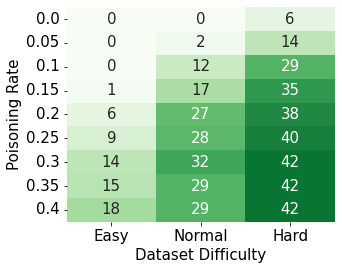

In [11]:
FONTSIZE = 15
FIGSIZE = (5, 4)

plt.rcParams["font.size"] = FONTSIZE
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.heatmap(pivot_mean, ax=ax, annot=True, fmt='.0f', cmap="Greens", vmin=0, vmax=50, cbar=False)
plt.yticks(rotation=0)
plt.tight_layout()
plot_output = os.path.join(path_output, 'synth_heatmap.svg')
plt.savefig(plot_output, dpi=300)